In [78]:
#All imports
import operator
from scipy import linalg
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,mean_squared_error,accuracy_score,classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import mixture
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import itertools
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.random_projection import GaussianRandomProjection
from scipy.linalg import pinv
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score

In [64]:
wine_quality_df = pd.read_csv("winequality-white.csv",delimiter=';')

In [65]:
wine_quality_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [66]:
wine_quality_df['quality_label'] = wine_quality_df['quality'].apply(lambda x: 0 if x<=5 else 1)
wine_quality_df = wine_quality_df.drop('quality',1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_4060\1925359153.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  wine_quality_df = wine_quality_df.drop('quality',1)


In [5]:
def use_standard_scaler(columns, df):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def use_normalizer(columns,df):
    scaler = Normalizer()
    df[columns] = scaler.fit_transform(df[columns])
    return df


def perform_label_and_one_hot_encoding(onehotencoder,df):
    """
    Function to perform label and one hot encoding on given dataframe
    Performs on 2 columns: Gender, Geography
    """

    df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
    df['Geography'] = LabelEncoder().fit_transform(df['Geography'])

    gender_df = pd.DataFrame(onehotencoder.fit_transform(df[['Gender']]).toarray())
    gender_df.columns = ['Male','Female']

    geography_df = pd.DataFrame(onehotencoder.fit_transform(df[['Geography']]).toarray())
    geography_df.columns = ['France','Germany','Spain']

    df = df.join(gender_df)
    df = df.join(geography_df)

    df.drop(['Gender', 'Geography'],
                  axis = 1,
                  inplace = True)
    
    return df

def apply_elbow_method(data):
    km = KMeans(init = 'k-means++',
                n_init = 10,
                max_iter = 100,
                random_state = 42)

    visualizer = KElbowVisualizer(km,
                                  k=(1,10))

    visualizer.fit(data)       
    visualizer.show()  

def apply_silhouette_method(data):
    fig, ax = plt.subplots(3, 2, figsize=(15,8))

    for i in [2, 3, 4, 5, 6, 7]:

        km_cluster = KMeans(n_clusters = i,
                            init = 'k-means++',
                            n_init = 10,
                            max_iter = 100,
                            random_state = 42)

        q, mod = divmod(i, 2)

        cluster_labels = km_cluster.fit_predict(data)

        silhouette_avg = silhouette_score(data,
                                          cluster_labels)

        print(f"Clusters: {i} | silhouette_avg: {silhouette_avg}")

        visualizer = SilhouetteVisualizer(km_cluster,
                                          colors = 'yellowbrick',
                                          ax = ax[q-1][mod])
        visualizer.fit(data) 

def find_best_param_gmm(data):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 5)
    cv_types = ["spherical", "tied", "diag", "full"]

    for cv_type in cv_types:
        for n_components in n_components_range:

            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)

            gmm.fit(data)
            bic.append(gmm.bic(data))

            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(["blue", "green", "orange", "pink"])
    clf = best_gmm
    bars = []


    plt.figure(figsize=(10, 12))

    spl = plt.subplot(2, 1, 1)

    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            plt.bar(xpos,
                    bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
                    width=0.2,
                    color=color))

    plt.xticks(n_components_range)

    plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])

    plt.title("BIC score per model")
    xpos = (
        np.mod(bic.argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(bic.argmin() / len(n_components_range))
    )
    plt.text(xpos,
             bic.min() * 0.97 + 0.03 * bic.max(), 
             "*",
             fontsize=14)

    spl.set_xlabel("Number of components")
    spl.legend([b[0] for b in bars], cv_types)

In [6]:
wine_quality_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [7]:
columns = [i for i in wine_quality_df.columns if i!='quality_label']
data_scaled = use_standard_scaler(columns, wine_quality_df)

In [8]:
data_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_label
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152,1
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276,1
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667,1
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,1
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,1


In [9]:
y = data_scaled['quality_label']
X = data_scaled.drop('quality_label', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_4060\2894887053.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = data_scaled.drop('quality_label', 1)


# K-means clustering

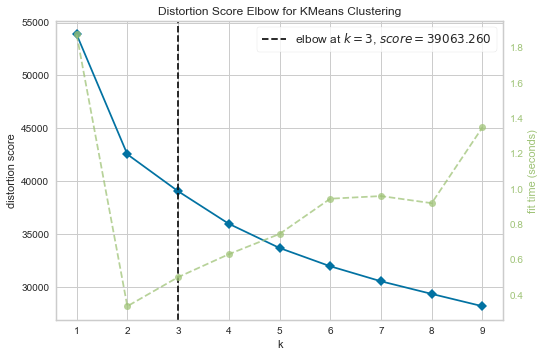

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
apply_elbow_method(X)

Clusters: 2 | silhouette_avg: 0.21447656060338416
Clusters: 3 | silhouette_avg: 0.14442082890834437
Clusters: 4 | silhouette_avg: 0.15898404552918058
Clusters: 5 | silhouette_avg: 0.14371819320325505
Clusters: 6 | silhouette_avg: 0.1455108240137917
Clusters: 7 | silhouette_avg: 0.12576526655740575


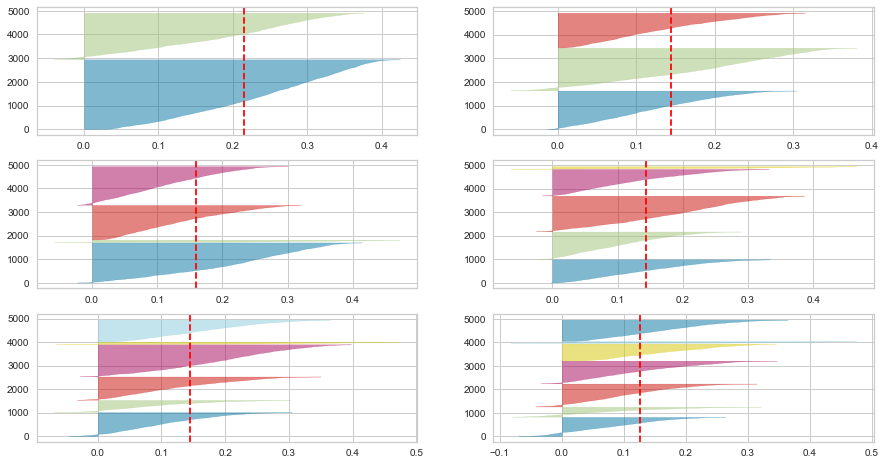

In [26]:
apply_silhouette_method(X) 

In [30]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 39063.29727773627
Silhouette score: 0.14442082890834437


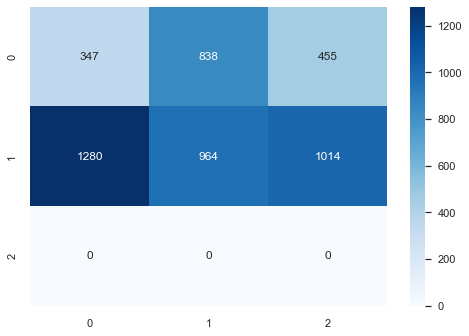

In [31]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [15]:
print(completeness_score(list(y), list(km_cluster.labels_)))
print(homogeneity_score(list(y), list(km_cluster.labels_)))

0.023433735261735106
0.04025316633468666


# Gaussian Mixture Model

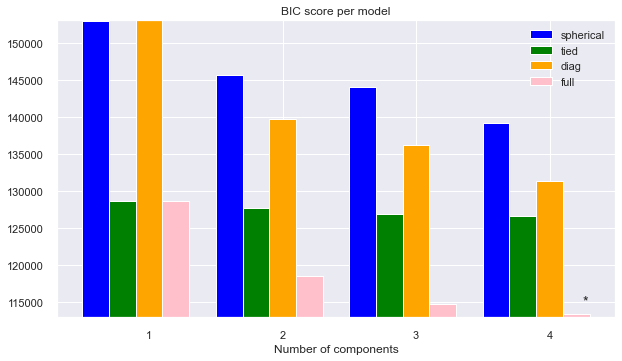

In [27]:
find_best_param_gmm(X)

In [13]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X)
gmm_labels = gmm.predict(X)

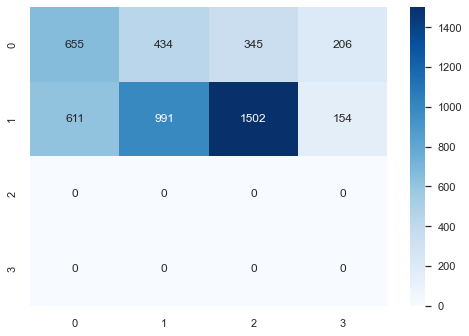

In [14]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [15]:
print(completeness_score(list(y), list(gmm_labels)))
print(homogeneity_score(list(y), list(gmm_labels)))

0.03780089906108421
0.07521337279676128


# PCA

In [11]:
pca = PCA().fit(X)

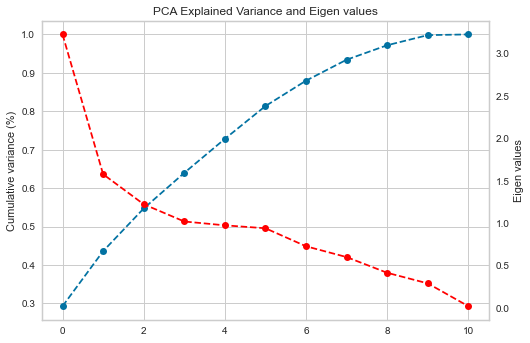

In [12]:
plt.figsize = (9,6)
fig, ax1 = plt.subplots()

x_axis1 = list(range(len(pca.explained_variance_ratio_)))
y_axis1 = np.cumsum(pca.explained_variance_ratio_)

x_axis2 = list(range(len(pca.explained_variance_)))
y_axis2 =  pca.explained_variance_

ax1.plot(x_axis1,
         y_axis1,
         marker='o',
         linestyle='--')
ax1.set_ylabel('Cumulative variance (%)')

ax2 = ax1.twinx()
ax2.plot(x_axis2,
         y_axis2,
         marker='o',
         linestyle='--',
         color = 'red')
ax2.set_ylabel('Eigen values')

plt.grid(False)
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance and Eigen values')
plt.show()

In [32]:
X_PCA = PCA(7).fit_transform(X)

# K-means after PCA

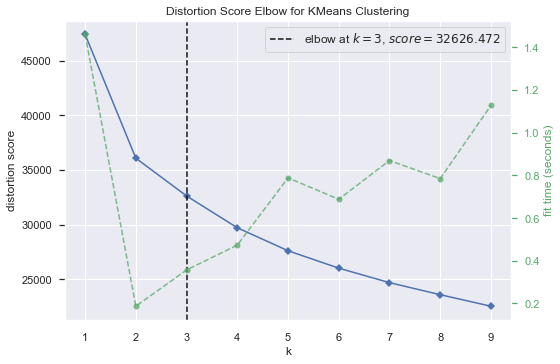

In [30]:
apply_elbow_method(X_PCA)

Clusters: 2 | silhouette_avg: 0.2403321163616335
Clusters: 3 | silhouette_avg: 0.16920918170930727
Clusters: 4 | silhouette_avg: 0.18430463151996224
Clusters: 5 | silhouette_avg: 0.16613317084919058
Clusters: 6 | silhouette_avg: 0.14543969354002734
Clusters: 7 | silhouette_avg: 0.1414135252672129


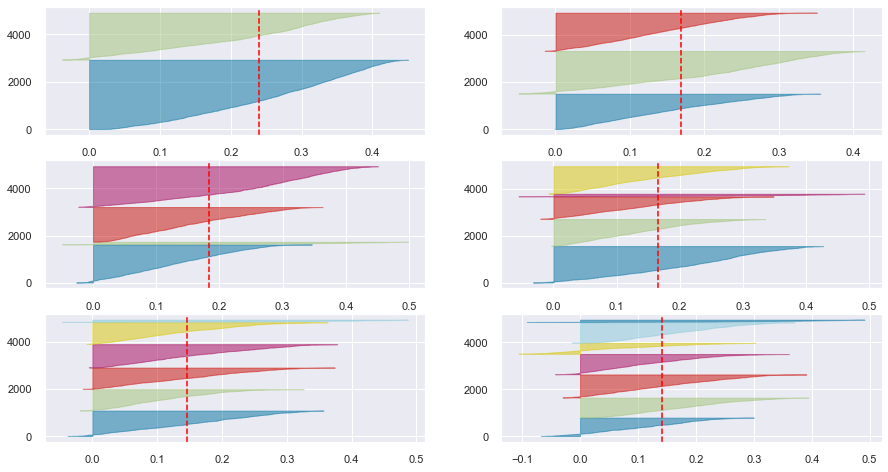

In [31]:
apply_silhouette_method(X_PCA)

In [33]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_PCA)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_PCA, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 32626.532816602845
Silhouette score: 0.16920918170931307


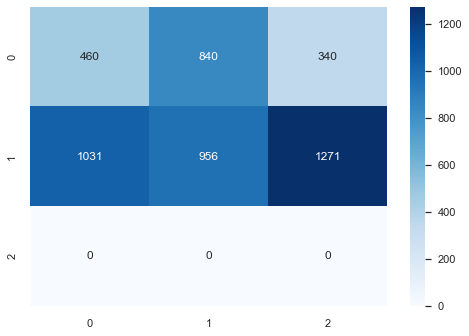

In [34]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [35]:
km_pca_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after PCA

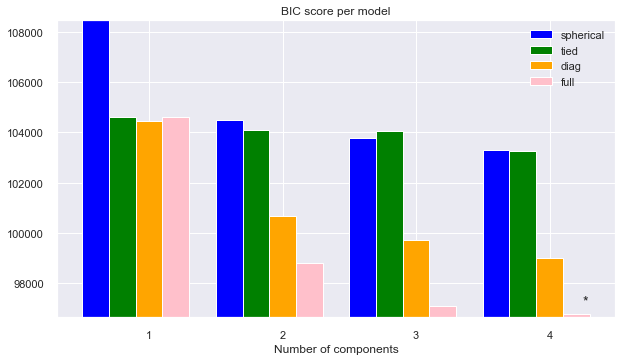

In [34]:
find_best_param_gmm(X_PCA)

In [36]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X_PCA)
gmm_labels = gmm.predict(X_PCA)

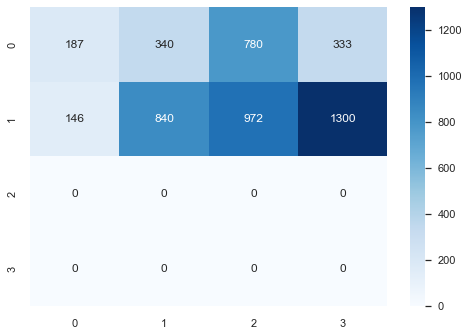

In [37]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [38]:
gmm_pca_labels = list(gmm_labels)

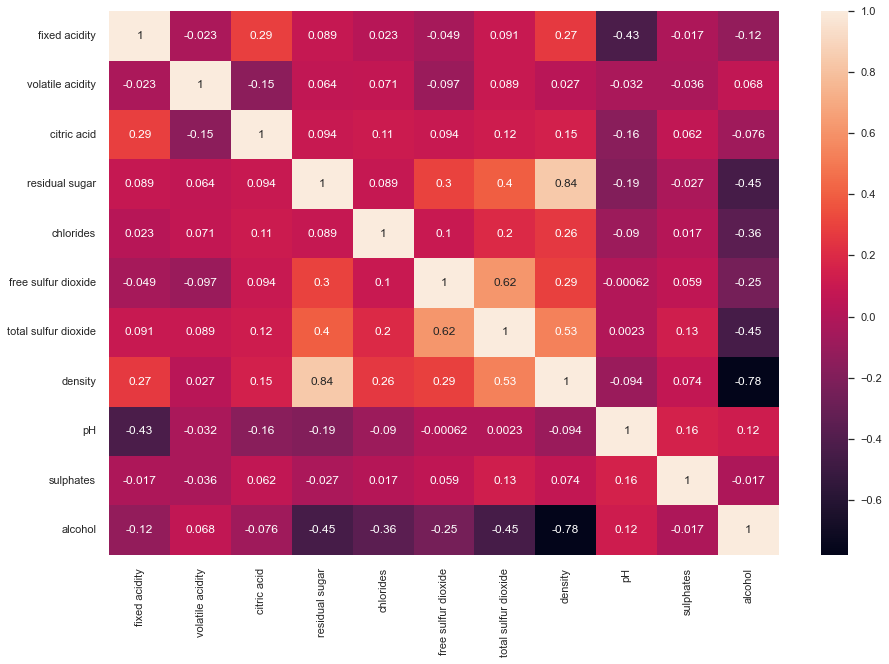

In [39]:
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrMatrix, annot=True)
plt.show()     

# ICA

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:468: UserWarning: n_components is too large: it will be set to 11
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:468: UserWarning: n_components is too large: it will be set to 11
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:468: UserWarning: n_components is too large: it will be set to 11
  warnings.warn(


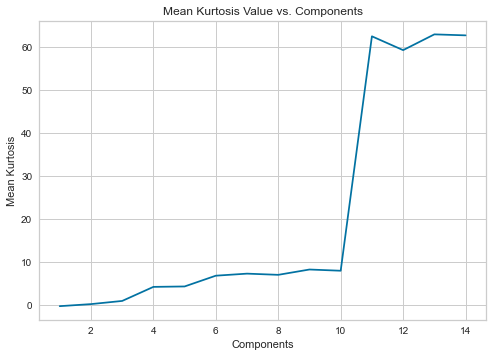

In [19]:
kurtosis_values = []
for i in range(1,15):
    X_ICA = FastICA(n_components = i).fit_transform(X)
    kur = kurtosis(X_ICA)
    kurtosis_values.append(np.mean(kur))
kurtosis_values = np.array(kurtosis_values)
plt.plot(np.arange(1,15),kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Mean Kurtosis')
plt.title('Mean Kurtosis Value vs. Components')
plt.show()

In [40]:
X_ICA = FastICA(n_components = 11).fit_transform(X)

# X_ICA_train,X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA,
#                                                                     y,
#                                                                     test_size = 0.2,
#                                                                     random_state = 42)

# K-means after ICA

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


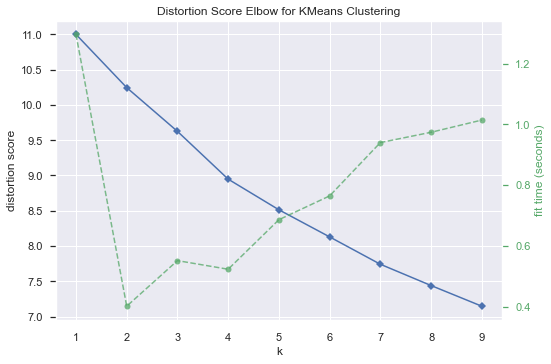

In [38]:
apply_elbow_method(X_ICA)

Clusters: 2 | silhouette_avg: 0.08697847300446011
Clusters: 3 | silhouette_avg: 0.08601704118515077
Clusters: 4 | silhouette_avg: 0.09567772653873544
Clusters: 5 | silhouette_avg: 0.09743089383610622
Clusters: 6 | silhouette_avg: 0.09851444954148676
Clusters: 7 | silhouette_avg: 0.10585992582434703


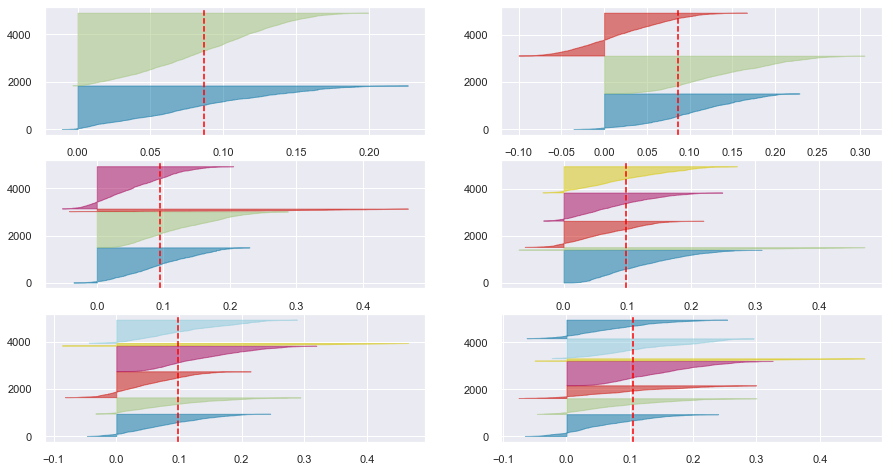

In [39]:
apply_silhouette_method(X_ICA)

In [41]:
k = 4
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_ICA)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_ICA, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 8.948343497418248
Silhouette score: 0.09567772653849556


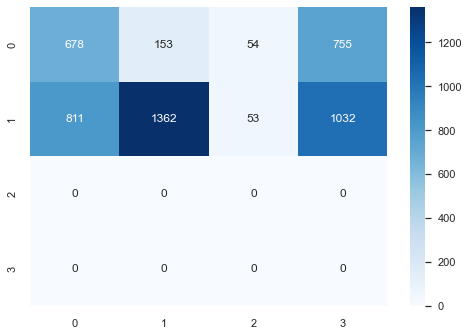

In [42]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [43]:
km_ica_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after ICA

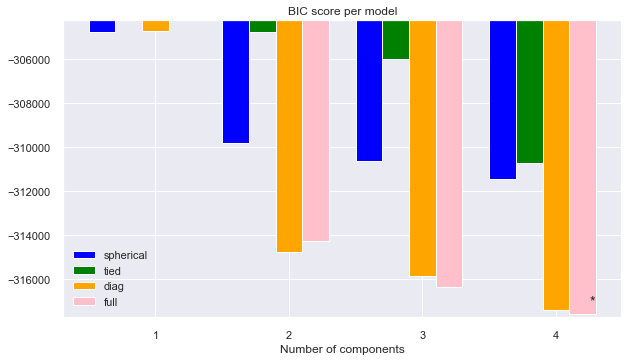

In [42]:
find_best_param_gmm(X_ICA)

In [44]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X_ICA)
gmm_labels = gmm.predict(X_ICA)

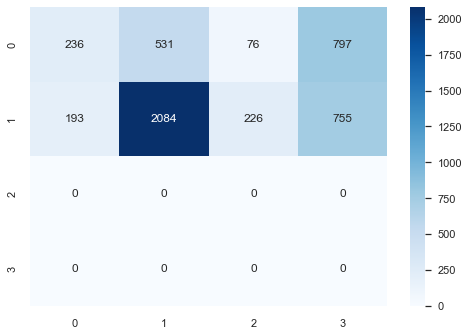

In [45]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [46]:
gmm_ica_labels = list(gmm_labels)

# GaussianRandomProjection

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (11 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

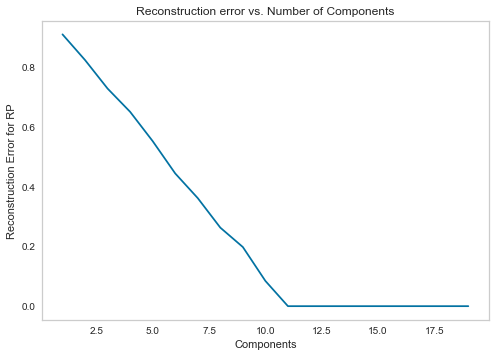

In [14]:
reconstruction_error = []

for i in range(1,20):
    mean_mse = []
    
    for j in range(0,20):
        
        X_RP = GaussianRandomProjection(n_components=i).fit(X)
        
        w = X_RP.components_
        p = pinv(w)

        mean_mse.append(mean_squared_error(X,((p@w)@(X.T)).T))
        
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)
plt.plot(np.arange(1,20),reconstruction_error)

plt.xlabel('Components')
plt.ylabel('Reconstruction Error for RP')
plt.title('Reconstruction error vs. Number of Components')
plt.grid()
plt.show()

In [95]:
X_RP = GaussianRandomProjection(n_components = 7).fit_transform(X)
# X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.2, random_state=42)

# K-means after GaussianRandomProjection

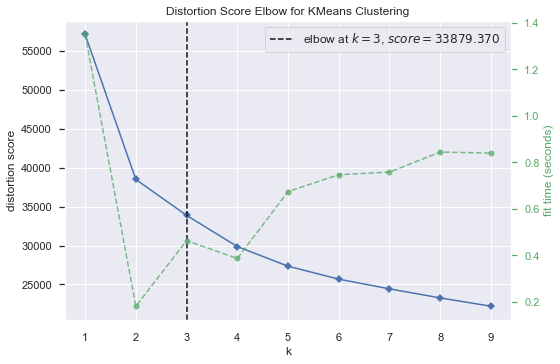

In [47]:
apply_elbow_method(X_RP)

Clusters: 2 | silhouette_avg: 0.28846025589797947
Clusters: 3 | silhouette_avg: 0.18711714010419492
Clusters: 4 | silhouette_avg: 0.19508292207152478
Clusters: 5 | silhouette_avg: 0.19041090793110224
Clusters: 6 | silhouette_avg: 0.1739523466030706
Clusters: 7 | silhouette_avg: 0.16725252197367949


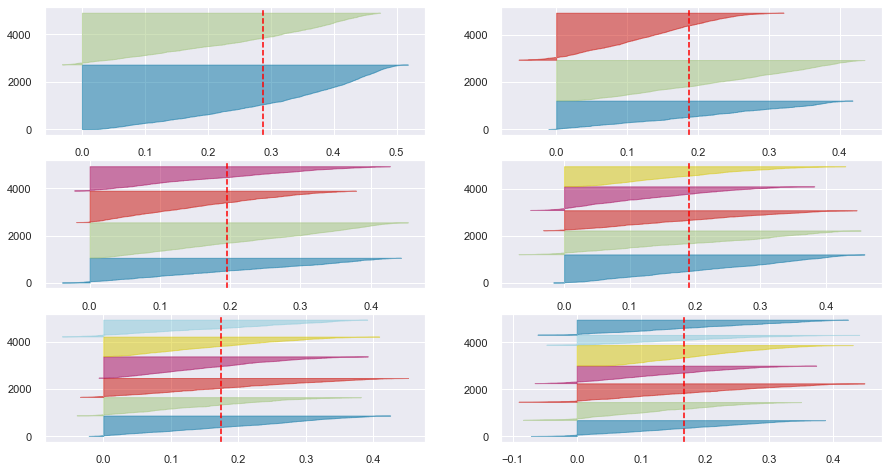

In [48]:
apply_silhouette_method(X_RP)

In [48]:
k = 4
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_RP)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_RP, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 34313.52293735147
Silhouette score: 0.18722553013417875


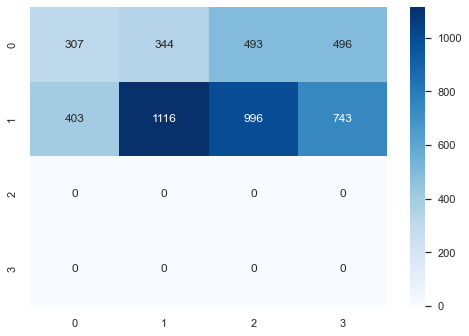

In [49]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [50]:
km_grp_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after GaussianRandomProjection

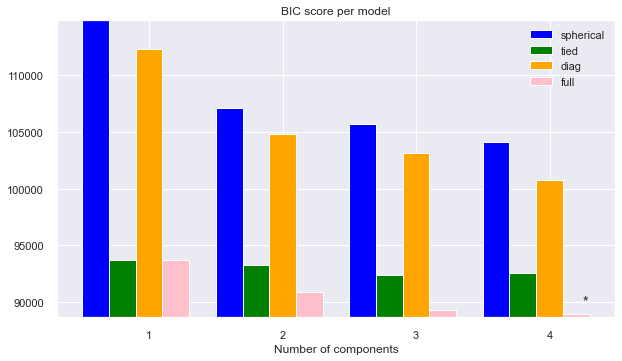

In [57]:
find_best_param_gmm(X_RP)

In [51]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X_RP)
gmm_labels = gmm.predict(X_RP)

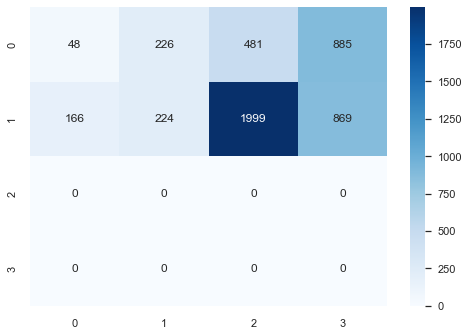

In [52]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [53]:
gmm_grp_labels = list(gmm_labels)

# ExtraTreesClassifier

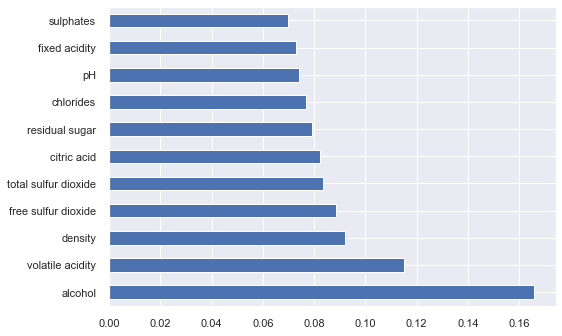

In [62]:
model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [54]:
X_feat = X[['alcohol','volatile acidity','density','free sulfur dioxide','citric acid','residual sugar']]

# K-means after Feature Selection

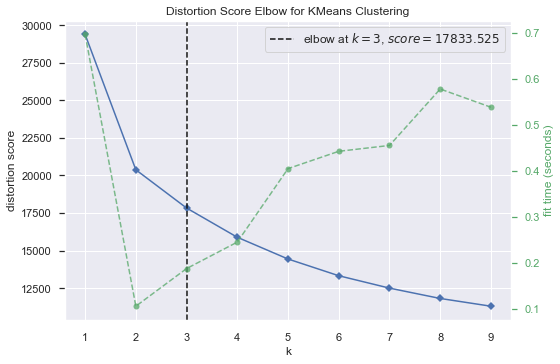

In [64]:
apply_elbow_method(X_feat)

Clusters: 2 | silhouette_avg: 0.3007126835346273
Clusters: 3 | silhouette_avg: 0.2132581879367189
Clusters: 4 | silhouette_avg: 0.21262863543346183
Clusters: 5 | silhouette_avg: 0.2083645853567655
Clusters: 6 | silhouette_avg: 0.19802500032708026
Clusters: 7 | silhouette_avg: 0.18005189383866715


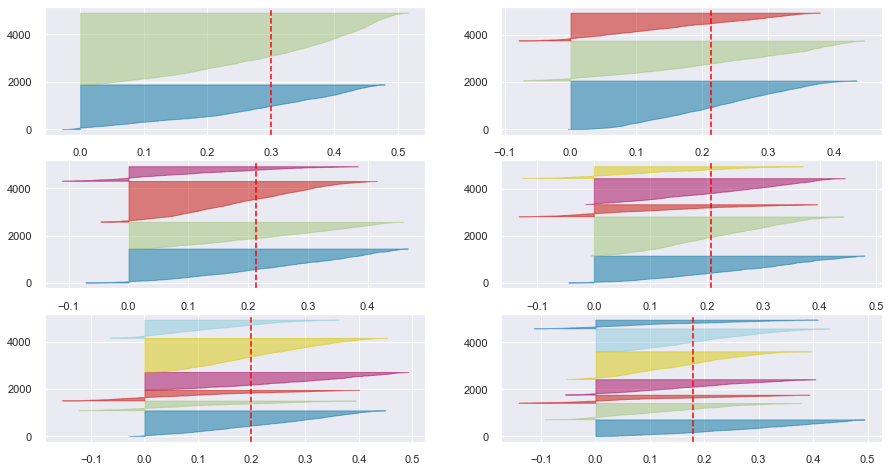

In [65]:
apply_silhouette_method(X_feat)

In [55]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_feat)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_feat, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 17833.58403287129
Silhouette score: 0.2132581879367189


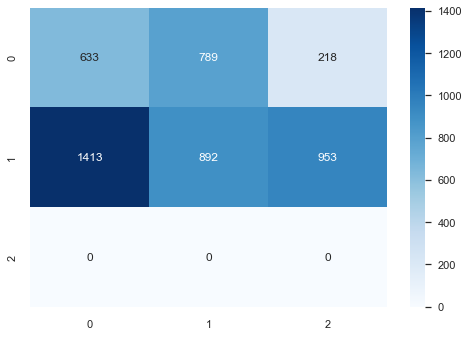

In [56]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [57]:
km_fs_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after Feature Selection

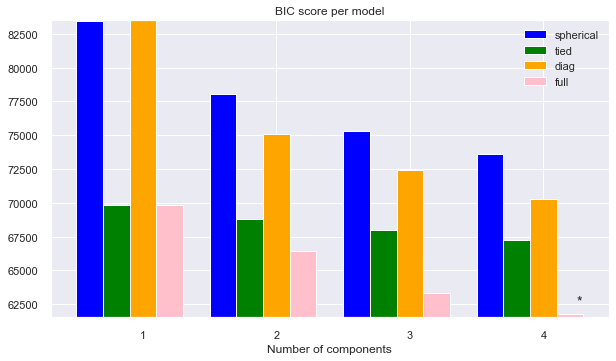

In [68]:
find_best_param_gmm(X_feat)

In [58]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'tied')
gmm.fit(X_feat)
gmm_labels = gmm.predict(X_feat)

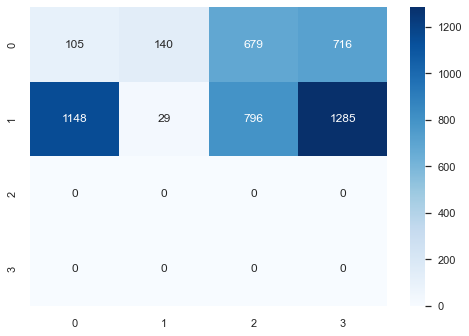

In [59]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [60]:
gmm_fs_labels = list(gmm_labels)

# Using clustering results as features on original data and running NN

In [68]:
"""
Split data in train and test set before performing data visualizations
80% training and 20% testing
"""
train_df, test_df = train_test_split(wine_quality_df,
                                     test_size = 0.2,
                                     random_state = 42)

train_df.reset_index(drop = True,
                     inplace = True)
test_df.reset_index(drop = True,
                    inplace = True)

print("Training set: {}".format(train_df.shape))
print("Testing set: {}".format(test_df.shape))



columns = [i for i in wine_quality_df.columns if i!='quality_label']

train_df = use_standard_scaler(columns, train_df)
test_df = use_standard_scaler(columns, test_df)


y_train = train_df['quality_label']
X_train = train_df.drop('quality_label', 1)

y_test = test_df['quality_label']
X_test = test_df.drop('quality_label', 1)

Training set: (3918, 12)
Testing set: (980, 12)


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Hp\AppData\Local\Temp\ipykernel_4060\3780494719.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be ke

In [69]:
pca = PCA(7)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)



ica = FastICA(n_components = 11)
ica.fit(X_train)
X_train_ICA = ica.transform(X_train)
X_test_ICA = ica.transform(X_test)


grp = GaussianRandomProjection(n_components = 7)
grp.fit(X_train)
X_train_GRP = grp.transform(X_train)
X_test_GRP = grp.transform(X_test)


X_train_feat = X_train[['alcohol','volatile acidity','density','free sulfur dioxide','citric acid','residual sugar']]
X_test_feat = X_test[['alcohol','volatile acidity','density','free sulfur dioxide','citric acid','residual sugar']]

In [70]:
#******************DEFINING FUNCTIONS*****************

def run_basic_nn(train_input,
                  train_output,
                  test_input,
                  test_output):

    
    clf = MLPClassifier()

    model = clf.fit(train_input, train_output)
    
    test_predictions = model.predict(test_input)
    train_prediction = model.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))


def find_best_activation_func(train_input,
                              train_output,
                              test_input,
                              test_output):
    
    activ_func = {}
    activation_funcs= ['identity','logistic','tanh','relu']
    for i in activation_funcs:

        clf = MLPClassifier(activation = i)
        clf.fit(train_input, train_output)
        test_predictions = clf.predict(test_input)
        activ_func[i] = accuracy_score(test_output, test_predictions)


    activ_func = dict(sorted(activ_func.items(), key=operator.itemgetter(1),reverse=True))
    print(activ_func)

    activ_funcs = list(activ_func.keys())
    accuracy = list(activ_func.values())

    fig = plt.figure(figsize = (5, 3.5))

    plt.bar(activ_funcs,accuracy, color ='red',width = 0.4)

    plt.xlabel("Activation function")
    plt.ylabel("Accuracy")
    plt.title("Activation function VS accuries")
    plt.show()
    
def select_best_parameters_nn(train_input, train_output,
                             hidden_layer_sizes,activation):


    param_grid = {'hidden_layer_sizes': hidden_layer_sizes,
                  'activation': activation}

    boost = GridSearchCV(estimator = MLPClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)

def best_model_nn(train_input,
                   train_output,
                   test_input,
                   test_output,
                   hidden_layer_sizes,
                   activation):
    
    clf = MLPClassifier(hidden_layer_sizes =  hidden_layer_sizes,
                        activation = activation)
    
    clf.fit(train_input, train_output)

    test_predictions = clf.predict(test_input)
    train_predictions = clf.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))
    return confusion_matrix(test_output,test_predictions,labels=[0,1])

def find_best_hidden_layers_size(train_input,
                                 train_output,
                                 test_input,
                                 test_output,
                                 hidden_layer_sizes_li):
    
    hidden_layer_sizes_li = hidden_layer_sizes_li
    
    accuracy_test = []
    accuracy_train = []

    for i in hidden_layer_sizes_li:    
        
        clf = MLPClassifier(hidden_layer_sizes=(i,), activation='logistic', )
        clf.fit(train_input, train_output)
        
        predictions_test = clf.predict(test_input)
        predictions_train = clf.predict(train_input)
        
        accuracy_test.append(accuracy_score(test_output, predictions_test))
        accuracy_train.append(accuracy_score(train_output, predictions_train))
      
    plt.plot(hidden_layer_sizes_li, accuracy_test, 'o-', color='red', label='Test Score')
    plt.plot(hidden_layer_sizes_li, accuracy_train, 'o-', color = 'blue', label='Train Score')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Hidden Units')
    
    plt.title("Validation curve")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [71]:
def hot_encode_clusters(df,labels_df):

    df1 = pd.DataFrame(onehotencoder.fit_transform(labels_df[['labels']]).toarray())

    df = df.join(df1)
#     print(df)

#     df.drop(['labels'],axis = 1,inplace = True)
    
    return df

In [73]:
def split_train_test(data):
    train_df, test_df = train_test_split(data,
                                 test_size = 0.2,
                                 random_state = 42)

    train_df.reset_index(drop = True,
                 inplace = True)
    test_df.reset_index(drop = True,
                inplace = True)
    y_train = train_df['quality_label']
    X_train = train_df.drop('quality_label', 1)

    y_test = test_df['quality_label']
    X_test = test_df.drop('quality_label', 1)
    
    return X_train, y_train, X_test, y_test

In [74]:
km_pca_labels_df = hot_encode_clusters(X,pd.DataFrame(km_pca_labels,columns = ['labels']))
gmm_pca_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_pca_labels,columns = ['labels']))

km_ica_labels_df = hot_encode_clusters(X,pd.DataFrame(km_ica_labels,columns = ['labels']))
gmm_ica_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_ica_labels,columns = ['labels']))

km_grp_labels_df = hot_encode_clusters(X,pd.DataFrame(km_grp_labels,columns = ['labels']))
gmm_grp_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_grp_labels,columns = ['labels']))

km_fs_labels_df = hot_encode_clusters(X,pd.DataFrame(km_fs_labels,columns = ['labels']))
gmm_fs_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_fs_labels,columns = ['labels']))

y_df = pd.DataFrame(y)

In [88]:
X_train, y_train, X_test, y_test = split_train_test(gmm_fs_labels_df.join(y_df))

C:\Users\Hp\AppData\Local\Temp\ipykernel_4060\2362589775.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train_df.drop('quality_label', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_4060\2362589775.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test_df.drop('quality_label', 1)


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'tanh': 0.7877551020408163, 'relu': 0.7877551020408163, 'logistic': 0.7591836734693878, 'identity': 0.7489795918367347}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


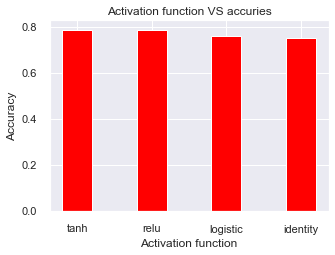

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'identity': 0.7551020408163265, 'relu': 0.7540816326530613, 'tanh': 0.7520408163265306, 'logistic': 0.7459183673469387}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


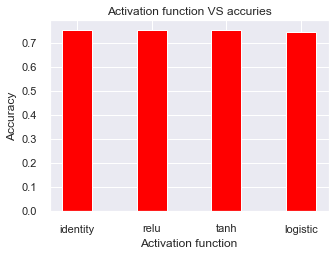

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'relu': 0.7581632653061224, 'tanh': 0.7561224489795918, 'logistic': 0.7326530612244898, 'identity': 0.7295918367346939}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


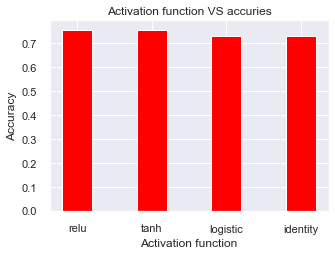

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'relu': 0.7683673469387755, 'tanh': 0.753061224489796, 'identity': 0.7448979591836735, 'logistic': 0.7428571428571429}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


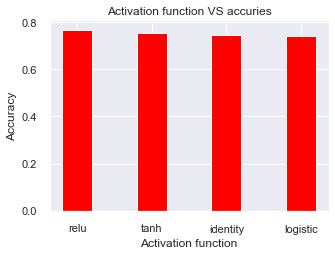

In [80]:
from sklearn.neural_network import MLPClassifier
find_best_activation_func(X_train, y_train, X_test, y_test)
find_best_activation_func(X_train_ICA, y_train, X_test_ICA, y_test)
find_best_activation_func(X_train_GRP, y_train, X_test_GRP, y_test)
find_best_activation_func(X_train_feat, y_train, X_test_feat, y_test)

In [82]:
from sklearn.model_selection import GridSearchCV
hidden_layer_sizes = [60,70,80,90,100,110,120,130,140,150]
activation = ['tanh','logistic']

select_best_parameters_nn(X_train, y_train, hidden_layer_sizes,activation)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

Per Hyperparameter tuning, best parameters are:
{'activation': 'tanh', 'hidden_layer_sizes': 70}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [90]:
best_model_nn(X_train, y_train, X_test, y_test,70,'tanh')
best_model_nn(X_train_ICA,y_train,X_test_ICA,y_test,120,'relu')
best_model_nn(X_train_GRP,y_train,X_test_GRP,y_test,100,'tanh')
best_model_nn(X_train_feat,y_train,X_test_feat,y_test,80,'tanh')

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train score 0.8208269525267994
Test score 0.7918367346938775
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       321
           1       0.84      0.86      0.85       659

    accuracy                           0.79       980
   macro avg       0.76      0.76      0.76       980
weighted avg       0.79      0.79      0.79       980

Train score 0.7608473711077081
Test score 0.7540816326530613
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       321
           1       0.79      0.86      0.82       659

    accuracy                           0.75       980
   macro avg       0.72      0.70      0.71       980
weighted avg       0.75      0.75      0.75       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train score 0.7797345584481878
Test score 0.7561224489795918
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       321
           1       0.80      0.84      0.82       659

    accuracy                           0.76       980
   macro avg       0.72      0.71      0.72       980
weighted avg       0.75      0.76      0.75       980

Train score 0.7751403777437468
Test score 0.7612244897959184
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       321
           1       0.80      0.86      0.83       659

    accuracy                           0.76       980
   macro avg       0.73      0.71      0.72       980
weighted avg       0.75      0.76      0.76       980



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[178, 143],
       [ 91, 568]], dtype=int64)